In [4]:
from utils.utils import *
from utils.ee_utils import *
from utils.utils import TextColors as tc
import ee
import geemap
from rois import ROIS
rois = ROIS()
from IPython.display import display

In [5]:
ee.Initialize()
Map = geemap.Map()

In [6]:
vis_params_s1_bright = {
    'min': -10,
    'max': 10,
    'bands': ['VV_db']
}

# ShowCase Examples
this is a file that contains codes that were removed but are importat, since they were used to test some theories

## High cloud cover results in false snow_cover result in sentinel 2 images

For exapmle in this case, we are testing an image in summer in paris, but as you can see we are seeing a high snow/ice coverege and that is because there is a high snow covege.

<span style="color: #FFFF11;">This is the reason we are not using snow removal on summer dataset anymore.</span>

If you want to use snow removal, you need to <span style="color: #FF4444;">make sure that the `cloud_cover` is low in the scene.</span>
- in our case we are using our custom cloud_cover check, which only checks our `roi`, so the whole scene could still be cloudy, and thus wrong snow_cover.

In [28]:
roi = rois.bercy

s2_test_col = ee.ImageCollection('COPERNICUS/S2_SR') \
                    .filterDate('2021-05-17', '2021-05-19') \
                    .filterBounds(roi)
                    
sen2_print(s2_test_col)
s2_test_img = s2_test_col.first()

scl = s2_test_img.select('SCL')
mask = scl.eq(11)

Map = geemap.Map()
Map.addLayer(s2_test_img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image', True)
Map.addLayer(mask.updateMask(mask), {'palette': 'blue'}, 'Water Mask')
Map.centerObject(roi, zoom=10)
Map.addLayerControl()
Map


Map(center=[48.843641547684896, 2.380256652833762], controls=(WidgetControl(options=['position', 'transparent_…

## Sentinel 1A and 1B, Tandem Orbit 
sentinel 1a and 1b orbits result in a pretty simmilar, becuse of the short Spatial BaseLine.

- Although I still don't know, how can you determine whether two, realtive orbit numbers are tandem or not. -> <span style="color: #FF1111; text-decoration: line-through;">More Research Needed</span>

<span style="color: #11FF11;">Found The Answer - Read The Cells Below</span>


In [29]:
# Overwrite the default print function to for a consicise print
sen1_print = lambda s2_collection: ee_property_printer(s2_collection, propertie_name_list=['system:time_start','platform_number',
                                                                                                    'relativeOrbitNumber_start', 'orbitProperties_pass',
                                                                                                    'cycleNumber'], first_is_t_in_millis=True)

In [30]:
roi = rois.paris
# s2_col,s1_col = s1s2(roi,date = ('2021-07-15', '2021-08-15'),priority_path = 'DESCENDING',max_cloud = 100,max_snow = 100,month_span = 1,retry_days=0)
s1_col = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate('2021-06-24', '2021-08-20') \
    .filterBounds(roi) \
    .filter(ee.Filter.eq('resolution','H')) \
    .filter(ee.Filter.eq('instrumentMode','IW'))\
    .filter(ee.Filter.contains('.geo', roi)) \
    .filterMetadata('orbitProperties_pass', 'equals', 'DESCENDING') 
    
s1_col.size().getInfo()

20

### Finding the most occured orbit
well here both orbit `110` and `8` have equal passes.
But in other cases we would like to choose images that have more passes over the roi, to get a better `spackle` mitigation.

In [31]:
rel_list = s1_col.aggregate_array('relativeOrbitNumber_start')
x = find_most_repeated_element(rel_list)
x


There is a pattern `BA AB BA AB BA...` with each `BA` differing only **1** day and each `BA AB` having a **5** day difference

In [32]:
sen1_print(s1_col.sort('system:time_start'))

,Property,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,system:time_start,2021-06-25,2021-06-26,2021-07-01,2021-07-02,2021-07-07,2021-07-08,2021-07-13,2021-07-14,2021-07-19,2021-07-20,2021-07-25,2021-07-26,2021-07-31,2021-08-01,2021-08-06,2021-08-07,2021-08-12,2021-08-13,2021-08-18,2021-08-19
1,platform_number,B,A,A,B,B,A,A,B,B,A,A,B,B,A,A,B,B,A,A,B
2,relativeOrbitNumber_start,8,110,8,110,8,110,8,110,8,110,8,110,8,110,8,110,8,110,8,110
3,orbitProperties_pass,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING
4,cycleNumber,164,234,235,164,165,235,236,165,166,236,237,166,167,237,238,167,168,238,239,168


<span style="color: #dc0fff;">Let's devide this imageCollection, into two collections of `Only 1A` and `Only 1B`</span>

Hmmm... as you can see, the `1A` collection has `two` diffrent `relativeOrbitnumber`s which mean there are two diffrent scences covering this roi, form two diffrent angles!






In [33]:
sen1_a =s1_col.filter(ee.Filter.eq('platform_number', 'A')).sort('system:time_start')
sen1_print(sen1_a)

,Property,0,1,2,3,4,5,6,7,8,9
0,system:time_start,2021-06-26,2021-07-01,2021-07-08,2021-07-13,2021-07-20,2021-07-25,2021-08-01,2021-08-06,2021-08-13,2021-08-18
1,platform_number,A,A,A,A,A,A,A,A,A,A
2,relativeOrbitNumber_start,110,8,110,8,110,8,110,8,110,8
3,orbitProperties_pass,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING
4,cycleNumber,234,235,235,236,236,237,237,238,238,239


Let's visualize this:

In [34]:
sen1a_110 = toDb(sen1_a.filter(ee.Filter.eq('relativeOrbitNumber_start', 110)).sort('system:time_start').map(toLinear).mean().clip(roi))
sen1a_8 = toDb(sen1_a.filter(ee.Filter.eq('relativeOrbitNumber_start', 8)).sort('system:time_start').map(toLinear).mean().clip(roi))
left_layer = geemap.ee_tile_layer(sen1a_110, vis_params_s1_bright, 'sen1a_110')
right_layer = geemap.ee_tile_layer(sen1a_8, vis_params_s1_bright, 'sen1a_8')
Map = geemap.Map(zoom=12)
Map.centerObject(roi)
Map.split_map(left_layer, right_layer)
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Average Viewing angle of each Image in the roi
Here we can see that orbit `110` has a much steeper `incident angle`, in a case where we have oribts with equal passes over the roi, we want to choose the images that have a higher incidetn angle, thus finder grain detail.

In [35]:
display(get_band_average(sen1a_8,'angle'),
        get_band_average(sen1a_110,'angle'))

We can also see that `sentinel-1b`, of the same orbits have almost `the same` incident angle as `1a`

In [36]:
sen1_b =s1_col.filter(ee.Filter.eq('platform_number', 'B')).sort('system:time_start')
sen1b_110 = toDb(sen1_a.filter(ee.Filter.eq('relativeOrbitNumber_start', 110)).sort('system:time_start').map(toLinear).mean().clip(roi))
sen1b_8 = toDb(sen1_a.filter(ee.Filter.eq('relativeOrbitNumber_start', 8)).sort('system:time_start').map(toLinear).mean().clip(roi))
display(get_band_average(sen1b_8,'angle'),
        get_band_average(sen1b_110,'angle'))

The same for 1B

In [37]:
sen1_print(s1_col.filter(ee.Filter.eq('platform_number', 'B')).sort('system:time_start'))

,Property,0,1,2,3,4,5,6,7,8,9
0,system:time_start,2021-06-25,2021-07-02,2021-07-07,2021-07-14,2021-07-19,2021-07-26,2021-07-31,2021-08-07,2021-08-12,2021-08-19
1,platform_number,B,B,B,B,B,B,B,B,B,B
2,relativeOrbitNumber_start,8,110,8,110,8,110,8,110,8,110
3,orbitProperties_pass,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING
4,cycleNumber,164,164,165,165,166,166,167,167,168,168


### Let's deivde them by Oribt Number
`1A` and `1B` have the same Orbit Number over an Area!
- This is the Tandem Orbit
- So for consistat viewing geometry, filter by orbit number

In [38]:
print(tc.BOLD,'Relative orbit number 8: ',tc.ENDC)
sen1_print(s1_col.filter(ee.Filter.eq('relativeOrbitNumber_start', ee.Number(8))).sort('system:time_start'))


 Relative orbit number 8:  


,Property,0,1,2,3,4,5,6,7,8,9
0,system:time_start,2021-06-25,2021-07-01,2021-07-07,2021-07-13,2021-07-19,2021-07-25,2021-07-31,2021-08-06,2021-08-12,2021-08-18
1,platform_number,B,A,B,A,B,A,B,A,B,A
2,relativeOrbitNumber_start,8,8,8,8,8,8,8,8,8,8
3,orbitProperties_pass,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING
4,cycleNumber,164,235,165,236,166,237,167,238,168,239


In [39]:
print(tc.BOLD,'Relative orbit number 110: ',tc.ENDC)
sen1_print(s1_col.filter(ee.Filter.eq('relativeOrbitNumber_start', ee.Number(110))).sort('system:time_start'))

 Relative orbit number 110:  


,Property,0,1,2,3,4,5,6,7,8,9
0,system:time_start,2021-06-26,2021-07-02,2021-07-08,2021-07-14,2021-07-20,2021-07-26,2021-08-01,2021-08-07,2021-08-13,2021-08-19
1,platform_number,A,B,A,B,A,B,A,B,A,B
2,relativeOrbitNumber_start,110,110,110,110,110,110,110,110,110,110
3,orbitProperties_pass,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING
4,cycleNumber,234,164,235,165,236,166,237,167,238,168


### Comparing 1A and 1B on the same Orbit
lest filter the collection by only `orbit==8`, and then devide it into `1A` and `1B`

In [40]:
s1_col_8 = s1_col.filter(ee.Filter.eq('relativeOrbitNumber_start', ee.Number(8))).sort('system:time_start').map(toLinear)

In [41]:
s1a = toDb(s1_col_8.filter(ee.Filter.eq('platform_number', 'A')).mean().clip(roi))
s1b = toDb(s1_col_8.filter(ee.Filter.eq('platform_number', 'B')).mean().clip(roi))
left_layer = geemap.ee_tile_layer(s1a, vis_params_s1_bright, 'S1a')
right_layer = geemap.ee_tile_layer(s1b, vis_params_s1_bright, 'S1b')

<span style="color: #11FF11;">The Diffrence is a lot Less!</span>

- Corner reflectors stay a corner reflector! unlike diffrent orbits, these are `directional corner reflectors` the since the the dirrection in orbits change they might be a CR in one of them and not in the other!

- The spacle is higher since we devided the collection both by `A` and `B` and `relativeOrbit`

But we made out point!

Which  is: <span style="font-weight: bold; color: red;">USE ONLY ONE ORBIT</span>.

In [42]:
Map = geemap.Map(zoom=12)
Map.centerObject(roi)
Map.split_map(left_layer, right_layer)
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Viewing Angle

In [43]:
# Define an area of interest (AOI)
aoi = ee.Geometry.Point([-122.4439, 37.7538])

# Load the Sentinel-1 data collection
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate('2022-01-01', '2022-01-31') \
    .first()

# Select the 'angle' band
angle = sentinel1.select('angle')

# Define the visualization parameters
vis_params = {
    'min': 25,
    'max': 45,
    'palette': ['white', 'red']
}

# Display the image using geemap
Map = geemap.Map(center=[37.7538, -122.4439], zoom=10)
Map.addLayer(angle, vis_params, 'Angle')
#Map.addLayerControl()
#Map.setControlVisibility(layer_control=True, fullscreen_control=True, lat_lng_popup=True)
Map

Map(center=[37.7538, -122.4439], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

# Usage of new s1s2 funciton

In [44]:
s2_col,s1_col = s1s2(roi,date = ('2021-07-15', '2021-08-15'),priority_path = 'DESCENDING',max_cloud = 100,max_snow = 100,month_span = 1,retry_days=0)

 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-31
final date range:   2021-06-30 2021-08-31 | diff_days -> 62 
◍checking for DESCENDING single scene
Mosiac Covers 93.96914404374861 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 


In [45]:
sen1_print(s1_col.sort('system:time_start'))

,Property,0,1,2,3,4,5,6,7,8,9,10
0,system:time_start,2021-07-01,2021-07-07,2021-07-13,2021-07-19,2021-07-25,2021-07-31,2021-08-06,2021-08-12,2021-08-18,2021-08-24,2021-08-30
1,platform_number,A,B,A,B,A,B,A,B,A,B,A
2,relativeOrbitNumber_start,8,8,8,8,8,8,8,8,8,8,8
3,orbitProperties_pass,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING,DESCENDING
4,cycleNumber,235,165,236,166,237,167,238,168,239,169,240


In [46]:
sen2_print(s2_col.sort('system:time_start'))

,Property,0,1,2,3,4,5,6,7,8,9,10,11
0,system:time_start,2021-07-17,2021-07-19,2021-07-22,2021-07-24,2021-07-27,2021-07-29,2021-08-01,2021-08-03,2021-08-06,2021-08-08,2021-08-11,2021-08-13
1,roi_cloud_cover,67.854619,1.729341,0.024054,96.242133,73.843733,55.234140,34.977323,92.800953,67.789340,43.549789,49.704878,21.574414
2,CLOUDY_PIXEL_PERCENTAGE,91.437759,2.355076,0.408007,91.405566,98.069242,51.998403,41.787647,87.877446,85.708293,40.412823,54.434299,16.812056
3,CLOUD_SHADOW_PERCENTAGE,0.234356,0.077020,0.250338,0.041675,0,5.188723,6.418061,0.403764,0.173201,4.507200,3.396637,0.507126
4,VEGETATION_PERCENTAGE,3.170934,60.976559,59.382445,2.410075,0,21.865638,24.929944,3.434381,3.169664,26.205105,22.549260,49.780741
5,NOT_VEGETATED_PERCENTAGE,0.908962,35.378841,38.356686,2.211741,0.029859,13.423601,17.290862,1.420878,2.435716,14.814843,12.481698,29.063180
6,CLOUD_COVERAGE_ASSESSMENT,91.437759,2.355076,0.408007,91.405566,98.069242,51.998403,41.787647,87.877446,85.708293,40.412823,54.434299,16.812056
7,GENERATION_TIME,1626531140000,1626888199000,1626958595000,1627135119000,1627396094000,1627843878000,1627823281000,1627999643000,1628258833000,1628431847000,1628693377000,1628863429000
8,SENSING_ORBIT_NUMBER,94,51,94,51,94,51,94,51,94,51,94,51
9,NODATA_PIXEL_PERCENTAGE,26.479939,0.000056,26.772150,0,26.462221,0.000013,26.741484,0,26.404715,0.000040,26.570237,0.000109


In [47]:
class Bold_Background:
    BLACK = '\033[1;40m'
    RED = '\033[1;41m'
    GREEN = '\033[1;42m'
    YELLOW = '\033[1;43m'
    BLUE = '\033[1;44m'
    PURPLE = '\033[1;45m'
    CYAN = '\033[1;46m'
    WHITE = '\033[1;47m'

In [50]:
print(TextColors.HIGH_INTENSITY_BACKGROUNDs.BLUE,"HELLO",'\033[0m')
print(TextColors.BOLD_BAKGROUNDs.PURPLE,"HELLO",'\033[0m')
print(TextColors.HIGH_INTENSITYs.BLUE,"HELLO",'\033[0m')
print(TextColors.BLACK_TEXT_WIHT_BACKGROUNDs.GREEN,"HELLO",'\033[0m')


print('\033[48;2;50;50;100m',"HELLO",'\033[0m')


print('\033[38;2;165;165;0m',"HELLO",'\033[0m')


 HELLO 
 HELLO 
 HELLO 
 HELLO 
 HELLO 
 HELLO 


In [51]:
TextColors.BOLDs.GREEN

'\x1b'

In [52]:
import numpy as np

def divide_image(image):
    height, width, _ = image.shape
    patch_size = 256
    patches = []
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return np.array(patches)

In [53]:
min_left_out = float('inf')
min_left_out

inf

# Testing best overlap

In [54]:
import numpy as np
def divide_image(img):

    # Get the width and height of the input image
    width, height = img.shape

    # Initialize variables to store the best overlap value and the minimum number of pixels left out
    best_overlap = None
    min_left_out = float('inf')

    # Try different overlap values
    for overlap in range(1, 256):
        # Calculate the number of patches needed in both the x and y directions with the current overlap value
        x_patches = (width - overlap) // (256 - overlap)
        y_patches = (height - overlap) // (256 - overlap)

        # Calculate the total number of pixels left out with the current overlap value
        left_out = (width - (x_patches * 256 - (x_patches - 1) * overlap)) * (height - (y_patches * 256 - (y_patches - 1) * overlap))

        # Check if the current overlap value is better than the previous best overlap value
        if left_out < min_left_out:
            best_overlap = overlap
            min_left_out = left_out

    # Calculate the number of patches needed in both the x and y directions with the best overlap value
    x_patches = (width - best_overlap) // (256 - best_overlap)
    y_patches = (height - best_overlap) // (256 - best_overlap)

    # Loop through all the patches and extract them from the input image
    patch_stack = []
    for y in range(y_patches):
        for x in range(x_patches):
            left = x * (256 - best_overlap)
            top = y * (256 - best_overlap)
            right = left + 256
            bottom = top + 256
            patch = img[left:right, top:bottom]
            patch_stack.append(patch)
            return patch_stack
            # do something with the patch here, like save it to a new file or process it further
            
test_image = np.random.randint(0, 255, size=(765, 787), dtype=np.uint8)
patches = divide_image(test_image)
len(patches)


1

## Visuallizing the `SCL` and `QA60` Cloud and Shadow masks

In [1]:
import ee
import geemap
from utils.ee_utils import *
from utils.utils import *

In [2]:
ee.Initialize()
Map = geemap.Map()

In [3]:
from rois import ROIS
rois = ROIS()
troi = rois.hongkong


In [4]:
s2 = get_s2(('2019-08-07','2019-09-07'), troi, max_cloud = 50)
sen2_print(s2)

 ◍◍Finding S2 
 ◍Single scene coverege was found! 


,Property,0,1,2,3,4,5
0,system:time_start,2019-08-08,2019-08-08,2019-08-13,2019-08-13,2019-08-28,2019-08-28
1,roi_cloud_cover,33.550545,33.729854,25.971853,27.941887,39.512667,40.027301
2,CLOUDY_PIXEL_PERCENTAGE,8.778919,10.971131,30.368852,34.400475,99.965189,99.930996
3,CLOUD_SHADOW_PERCENTAGE,0.262485,0.355703,0.708737,0.835016,0,0
4,VEGETATION_PERCENTAGE,12.366406,12.262448,10.735075,10.913491,0.006489,0
5,NOT_VEGETATED_PERCENTAGE,5.642653,5.222380,3.864992,2.875908,0.000041,0.000025
6,CLOUD_COVERAGE_ASSESSMENT,8.778919,10.971131,30.368852,34.400475,99.965189,99.930996
7,GENERATION_TIME,1565251610000,1565251610000,1565679838000,1565679838000,1566982334000,1566982334000
8,SENSING_ORBIT_NUMBER,32,32,32,32,32,32
9,NODATA_PIXEL_PERCENTAGE,44.129515,61.158192,44.201723,61.230910,43.651044,60.675538


In [5]:
s2_img = s2.first().clip(troi)

scl = s2_img.select('SCL')
cloud_high = scl.eq(9)
cloud_med = scl.eq(8)
cloud_low = scl.eq(7)
shadow_mask = scl.eq(3)
dark_mask = scl.eq(2)

qa60 = s2_img.select('QA60')
cloud_qa = qa60.bitwiseAnd(1 << 10)


Map = geemap.Map()
Map.addLayer(s2_img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image', True)

Map.addLayer(qa60.updateMask(qa60), {'palette': '#FF11FF'}, 'Cloud QA')

Map.addLayer(cloud_high.updateMask(cloud_high), {'palette': '#1111FF'}, 'Cloud High')
Map.addLayer(cloud_med.updateMask(cloud_med), {'palette': '#111188'}, 'Cloud Med')
Map.addLayer(cloud_low.updateMask(cloud_low), {'palette': '#111155'}, 'Cloud Low')

Map.addLayer(shadow_mask.updateMask(shadow_mask), {'palette': 'green'}, 'Cloud Shadow Mask')
Map.addLayer(dark_mask.updateMask(dark_mask), {'palette': 'red'}, 'Dark pixel mask')
Map.centerObject(troi, zoom=10)
Map.addLayerControl()
Map

Map(center=[22.30886435509169, 114.25334930420124], controls=(WidgetControl(options=['position', 'transparent_…

The Sentinel-2 SCL (Scene Classification) band is used to identify different land cover types based on their spectral properties. The dark pixels in the SCL band are typically caused by shadows, water bodies, and other low reflectance surfaces that do not have a clear spectral signature that can be easily classified by the SCL algorithm.

Shadows are a common cause of dark pixels in the SCL band because they result in reduced reflectance from the affected areas. This is due to the blocking of direct sunlight by nearby objects such as buildings, trees, or terrain features. Shadows can be particularly prominent in urban areas, where there are many tall buildings and other structures that cast shadows over adjacent areas.

Water bodies also tend to have low reflectance in the SCL band, which can result in dark pixels. This is because water absorbs a significant amount of the incident sunlight and reflects very little of it. The SCL algorithm may also have difficulty distinguishing between water and other dark surfaces, such as shadows or low-reflectance land cover types.

Other factors that can contribute to dark pixels in the SCL band include cloud shadows, vegetation shadows, and areas of low reflectance due to soil or vegetation characteristics. These factors can make it difficult for the SCL algorithm to accurately classify land cover types in affected areas.

In [6]:
get_mask_ones_ratio(get_cloud_mask(s2.first())[2])

In [7]:
get_mask_ones_ratio(get_cloud_mask(s2.first().clip(troi))[2])

In [8]:
mask = scl.eq(3).Or(scl.eq(9)).Or(scl.eq(8))
get_mask_ones_ratio(mask.clip(troi))

In [9]:

get_mask_ones_ratio(get_cloud_mask_from_scl(s2.first().clip(troi)))

# Addin Dot to The Top left corner

In [7]:
roi = rois.beihai_buffed
bounds = roi.bounds().getInfo()['coordinates'][0]
bounds = list(set(tuple(x) for x in bounds))
bounds = [list(x) for x in bounds]
bounds

[[109.386406, 21.616579],
 [109.556351, 21.616579],
 [109.556351, 21.472559],
 [109.386406, 21.472559]]

In [8]:
smallest_coordinate = min(bounds, key=lambda coord: (coord[0], coord[1]))
smallest_coordinate

[109.386406, 21.472559]

In [9]:
tl_square = top_left_roi(roi)

In [10]:
Map = geemap.Map(zoom=12)
Map.addLayer(roi)
Map.addLayer(tl_square,{'color': '45ff45'})
Map.centerObject(roi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### testing on real images

In [11]:
s2_col,s1_col = s1s2(roi,date = ('2021-07-15', '2021-08-15'),priority_path = 'DESCENDING',max_cloud = 100,max_snow = 100,month_span = 2,retry_days=0)

 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-28
final date range:   2021-05-28 2021-09-28 | diff_days -> 123 
◍checking for DESCENDING single scene
◍DESCENDING singe scene was not fount, checking ASCENDING single scene ...
Mosiac Covers 98.70306840669505 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 


In [12]:
image = s1_col.mean().clip(roi)

In [13]:
image_with_dricetion_band = add_driection_band(image,roi)

In [14]:
image_with_dricetion_band.bandNames().getInfo()

['VV', 'VH', 'angle', 'constant']

In [15]:
constant_vis_params = {
    'min': 0,
    'max': 1,
    'bands': ['constant']
}

Map = geemap.Map()
Map.addLayer(image_with_dricetion_band, constant_vis_params, 'Image with constant band')
Map.centerObject(roi, zoom=10)
Map

Map(center=[21.544564264370536, 109.47137850000013], controls=(WidgetControl(options=['position', 'transparent…

### Downloading and checking the numpy array of the image

In [17]:
crs_= image_with_dricetion_band.select(0).projection().getInfo()
crs = crs_['crs']
crs_transform = crs_['transform']
(crs,crs_transform)

('EPSG:4326', [1, 0, 0, 0, 1, 0])

In [20]:
img_w_dir = image_with_dricetion_band.select('VV','constant')
geemap.download_ee_image(img_w_dir, "image_with_direciton_download.tif",crs='EPSG:4326' , scale=10,region = roi)

image_with_direciton_download.tif: |          | 0.00/48.6M (raw) [  0.0%] in 00:00 (eta:     ?)

In [21]:
geemap.ee_export_image(img_w_dir, "image_with_direciton_export.tif", crs='EPSG:4326', scale=10, region=roi)

Generating URL ...
Please wait ...
Data downloaded to d:\python\TemporalGAN\dataset\image_with_direciton_export.tif


In [25]:
from skimage import io
import matplotlib.pyplot as plt 

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bands(image):
    """
    Plots each band of an image represented as a numpy array
    """
    num_bands = image.shape[-1]
    fig, axs = plt.subplots(1, num_bands, figsize=(5*num_bands, 5))
    
    for i in range(num_bands):
        axs[i].imshow(image[:,:,i])
        axs[i].set_title(f'Band {i+1}')
        axs[i].axis('off')
    
    plt.show()

(2, 1604, 1893)
(1604, 1893, 2)


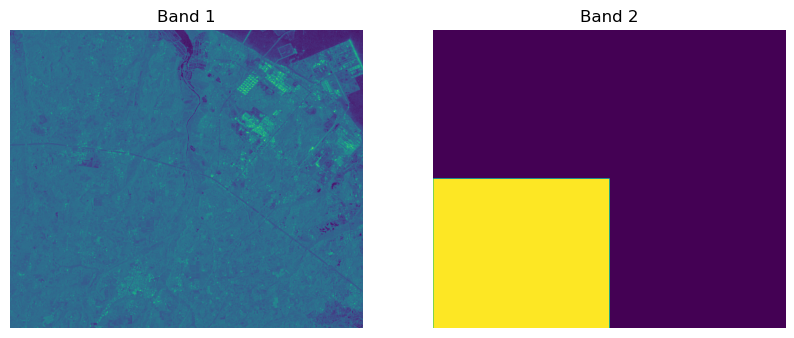

In [27]:
img = io.imread("image_with_direciton_download.tif")
print(img.shape)
img = reshape_array(img, channel_first = False)
print(img.shape)
plot_bands(img)

(1604, 1893, 2)
(1604, 1893, 2)


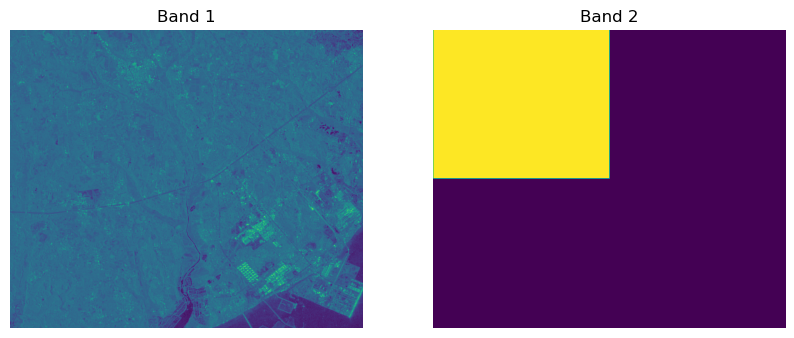

In [28]:
img = io.imread("image_with_direciton_export.tif")
print(img.shape)
img = reshape_array(img, channel_first = False)
print(img.shape)
plot_bands(img)